# C언어로 컴파일하기

작성자: 이성재

이 세미나에서는 파이썬 코드의 속도 향상을 위해 (1) 순수 파이썬 코드를 just in time(JIT) 컴파일러 `numba`로 컴파일하여 실행하거나, (2) C 코드를 작성한 후, `ctypes`를 이용하여 파이썬에서 사용하는 방법을 안내한다. 두 방법 모두 상당한 속도 향상 효과를 기대할 수 있으며 (1), (2)의 코드를 멀티코어에서 동작할 수 있게 병렬화한 구현도 제공한다.

## 라이브러리 설치 및 실습환경

이 세미나의 실습을 진행하기 위해서는 `numpy, scipy, numba, opencv-python, matplotlib`라이브러리가 필요하므로 다음과 같이 `pip`에서 설치한다.

```bash
pip install numpy scipy numba opencv-python matplotlib
```

성능 평가가 포함된 실습이므로 실습 중 나온 실행시간은 하드웨어 스펙에 따라 달라질 수 있다. 본 실습코드는 아래와 같은 환경에서 테스트되었다.

|Type|Specification|
|------|---|
|OS|Ubuntu 18.04|
|CPU|Intel Core i9-10900K @ 3.70 GHz|
|RAM|128 GB|

In [1]:
import cv2
import numpy as np
from conv2d import *
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# 성능 평가 예제 함수

이 세미나에서는 이미지 피라미드 연산을 예제로 사용한다.

## 이미지 피라미드

이미지 피라미드 연산 함수는 대규모 행렬 연산인 컨벌루션(convolution) 연산을 필요로 하는 동시에 현재 현대모비스 영상확대 과제에서 사용되고 있어 적절한 예제로 판단된다. 이미지 피라미드는 원본 이미지를 다운스케일(downscale)하는 알고리즘 중 하나로 다음과 같은 순서로 수행된다.

1. 가우시안 커널(Gaussian kernel)로 이미지를 필터링하여 블러링(blurring)한다.
2. 이미지의 홀수번째 인덱스만 선택한다.

이미지 피라미드를 사용하면 이미지의 노이즈를 최소화하면서 크기를 절반으로 다운스케일할 수 있다. phase-based magnification (PBM) 알고리즘에서는 원본 동영상의 크기가 아주 큰 경우, 이를 다운스케일할 때 이 알고리즘을 사용한다.

알고리즘을 조금 더 상세하게 설명하면 다음과 같다:

1. 입력 이미지 $\boldsymbol{x} \in \mathbb{R}^{H \times W \times C}$를 받는다.
2. $\boldsymbol{x}$에 크기 2 패딩을 적용하여 $\boldsymbol{x}_{\text{pad}} \in \mathbb{R}^{H+4 \times W+4 \times C}$를 생성한다. 이 과정은 컨벌루션 연산 수행 시 원본 이미지의 크기가 줄어드는 것을 방지하기 위해 수행된다.
3. 가우시안 컨벌루션 커널 $\boldsymbol{K \in \mathbb{R}^{5 \times 5}}$를 생성한다.
4. 채널별 컨벌루션 연산 $x'_{:, :, i} = \text{conv}(\boldsymbol{K}, x_{:, :, i}), \text{for} \ i=0,...,C-1$을 통해 블러링된 이미지 $\boldsymbol{x}' \in \mathbb{R}^{H \times W \times C}$을 생성한다.
5. 블러링된 이미지의 홀수번째 인덱스만 선택하여 출력 $\boldsymbol{y} \in \mathbb{R}^{(H+1)/2 \times (W+1)/2 \times C}$를 얻는다.

이미지 피라미드 연산은 $5 \times 5$크기의 가우시안 커널과 이미지를 합성곱하여 블러링을 수행한다. OpenCV의 [`pyrDown`](https://docs.opencv.org/3.4/d4/d1f/tutorial_pyramids.html) 함수 문서에서 커널의 값을 확인할 수 있다.

이 세미나에서 사용할 이미지 피라미드 연산은 `my_pyrdown`에 구현되어 있다. 이 함수는 사용할 컨벌루션 알고리즘을 두 번째 인자 `convfunc`로 받는다. 추후 성능을 테스트할 때 다양한 컨벌루션 구현을 입력하여 컴파일 유무에 따른 성능변화를 확인해 볼 것이다. 파이썬은 함수 또한 객체로 취급되어 인자로 넘길 수 있다.

## 컨벌루션 연산

이미지 피라미드의 핵심 연산은 컨벌루션 연산이다. 컨벌루션 연산은 커널을 슬라이딩 윈도우 방식으로 움직이면서 커널과 입력의 합성곱 연산을 통해 출력을 만들어낸다. 이 연산은 구현 자체는 간단하지만 기본적인 구현으로는 병렬화를 수행하는 게 거의 불가능하기 때문에 `cuDNN`이나 `XNNPack`같은 딥러닝 추론 백엔드는 훨씬 더 복잡한 최적화된 컨벌루션 연산을 구현해 놓았다. 그러나 이 튜토리얼에서는 JIT 컴파일러의 동작과 최적화 과정에 초점이 맞추어져 있기 때문에 간단한 컨벌루션 구현을 사용하도록 한다.

2차원 입력 데이터, 출력 데이터, 컨벌루션 연산의 가중치를 $\boldsymbol{x} \in \mathbb{R}^{H \times W}$, $\boldsymbol{y} \in \mathbb{R}^{H-Hk+1 \times W-Wk+1}$, $\boldsymbol{K} \in \mathbb{R}^{Hk \times Wk}$라고 할 때 출력 데이터의 각 원소는 다음과 같이 계산된다:

$y_{i, j} = \sum_{m=0}^{Hk} \sum_{n=0}^{Hw} x_{i+m, j+n} \cdot K_{m, n}$

In [2]:
def my_pyrdown(img, convfunc, **kwarg):
    h, w, c = img.shape
    dst_h, dst_w, dst_c = (h + 1) // 2, (w + 1) // 2, c
    dst = np.zeros((dst_h, dst_w, dst_c))
    impad = np.zeros((h+4, w+4, c))

    filter = np.array([[1., 4., 6., 4., 1.],
                       [4., 16., 24., 16., 4.],
                       [6., 24., 36., 24., 6.],
                       [4., 16., 24., 16., 4.],
                       [1., 4., 6., 4., 1.]])
    filter = filter / 256.

    impad[:,:,0] = np.pad(img[:,:,0], 2, mode="wrap")
    impad[:,:,1] = np.pad(img[:,:,1], 2, mode="wrap")
    impad[:,:,2] = np.pad(img[:,:,2], 2, mode="wrap")

    dst[:, :, 0] = convfunc(impad[:, :, 0], filter, **kwarg)[0::2, 0::2]
    dst[:, :, 1] = convfunc(impad[:, :, 1], filter, **kwarg)[0::2, 0::2]
    dst[:, :, 2] = convfunc(impad[:, :, 2], filter, **kwarg)[0::2, 0::2]

    return dst

# 기본 Python 구현

컨벌루션 연산을 그대로 파이썬으로 구현한 함수가 `conv2d_naive` 함수이다.

그러나 이 방법을 사용하면 계산복잡도가 높고 병렬화가 어렵다. 조금 더 효율적인 컨벌루션 알고리즘으로 `im2col`알고리즘이 있다. 이 알고리즘은 입력 이미지를 풀어서 컨벌루션 커널과의 행렬곱 연산 1번으로 컨벌루션을 계산할 수 있도록 한다. 이 알고리즘은 그림을 통해 이해하는 것이 편하므로 [다음 사이트](https://welcome-to-dewy-world.tistory.com/94)를 참고하면 좋다. `im2col`알고리즘은 `im2col` 함수로 구현했으며, `im2col`기반 컨벌루션은 `conv2d_unfold`함수로 구현했다.

유의점: 직관적인 이해를 돕고 눈에 띄는 성능 비교를 위해 아래의 코드는 `numpy` array에 대한 연산도 loop문으로 수행한다. 따라서 기본 구현의 성능이 아주 낮을 수 있다. 추후 이 부분은 `scipy`에 기본적으로 구현되어 있는 컨벌루션 연산인 `convolve2d`와도 비교될 것이다. 이 세미나의 목적은 파이썬 코드 컴파일 방식에 대해 설명하고 그 효과를 알아보는 것이 목적이므로, "효율적인 컨벌루션 연산을 파이썬 라이브러리로 구현하는 것"에는 집중하지 않았음에 유의한다.

실제 구현은 `conv2d.py` 파일에 있다.

```python
# #####################
# Pure Python
# #####################

def conv2d_naive(x: np.ndarray, k: np.ndarray):
    if x.ndim != 2:
        raise ValueError("Input data shape must be 2-dimensional.")
    if k.ndim != 2:
        raise ValueError("Kernel data shape must be 2-dimensional.")
    
    hx, wx = x.shape
    hk, wk = k.shape

    if hk > hx or wk > wx:
        raise ValueError("Kernel must not be larger than input data.")
    
    dst = np.zeros((hx-hk+1, wx-wk+1))
    
    for i in range(hx-hk+1):
        for j in range(wx-wk+1):
            for m in range(hk):
                for n in range(wk):
                    dst[i, j] += x[i+m, j+n] * k[m, n]

    return dst

def im2col(x: np.ndarray, filter_shape: np.ndarray):
    hx, wx = x.shape
    hk, wk = filter_shape[0], filter_shape[1]
    
    dst = np.zeros((hx-hk+1, wx-wk+1, hk, wk))

    for i in range(hx-hk+1):
        for j in range(wx-wk+1):
            for m in range(hk):
                for n in range(wk):
                    dst[i, j, m, n] = x[i+m, j+n]

    return dst.reshape((hx-hk+1)*(wx-wk+1), hk*wk)

def conv2d_unfold(x: np.ndarray, k: np.ndarray):
    if x.ndim != 2:
        raise ValueError("Input data shape must be 2-dimensional.")
    if k.ndim != 2:
        raise ValueError("Kernel data shape must be 2-dimensional.")
    
    hx, wx = x.shape
    hk, wk = k.shape

    if hk > hx or wk > wx:
        raise ValueError("Kernel must not be larger than input data.")
    
    col = im2col(x, np.array([hk, wk]))
    dst = (np.dot(col, k.reshape(hk*wk, 1))).reshape(hx-hk+1, wx-wk+1)

    return dst
```

## Python 연산 결과 확인

우선 기본적인 구현 내용으로 이미지 피라미드 연산을 수행하여 그 결과를 확인해 보았다. 원본 $512 \times 512$크기를 가진 `airplane.bmp`가 흐릿해지면서 축소되는 것을 확인할 수 있다. 그리고 기본 알고리즘과 `im2col` 알고리즘의 소요시간 차이를 확인해보자. 컴파일되지 않은 버전은 `%%timeit`으로 확인했을 때 시간이 꽤 걸린다.

컴파일을 수행하지 않은 코드를 사용하면 `im2col` 알고리즘을 사용했을 때 두 배 가까이 실행 속도가 빠르다.

Python, naive
6.63 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Python, im2col
3.62 s ± 721 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


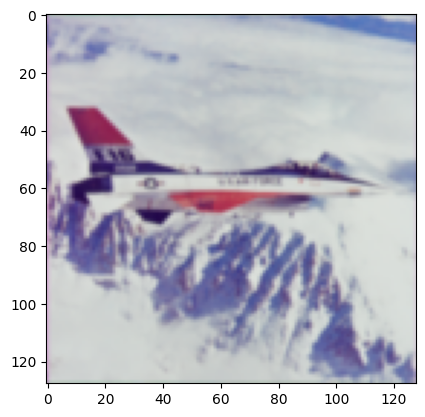

In [3]:
img = cv2.imread("./airplane.bmp")
img = (img / 255.).astype(np.float32)

imdown = my_pyrdown(img, conv2d_unfold)
imdown = my_pyrdown(imdown, conv2d_unfold)
imdown = (imdown*255.).astype(np.uint8)

plt.imshow(cv2.cvtColor(imdown, cv2.COLOR_BGR2RGB))

print("Python, naive")
%timeit imdown = my_pyrdown(img, conv2d_naive)
print("Python, im2col")
%timeit imdown = my_pyrdown(img, conv2d_unfold)

# JIT 컴파일 라이브러리 `numba`

`numba`는 LLVM 기반으로 파이썬 코드를 컴파일해주는 라이브러리이다. LLVM은 언어에 관계 없이 코드의 내용을 intermediate representation (IR)이라는 중간 표현으로 바꾼 후 최적화하여 머신코드를 만들어 준다. `numba`를 사용하면 사용자는 복잡한 과정을 거치지 않고 `@jit` 데코레이터만을 사용하여 함수를 컴파일할 수 있게 된다.

## `numba` 기반 컨벌루션 구현

함수를 JIT 컴파일하는 방법은 간단하다. 함수 위에 `@jit` 데코레이터만 입력해 주면 된다. 그리고 가장 높은 성능을 얻기 위해서는 `nopython`인자를 `True`로 설정해야 한다. 이 인자는 컴파일을 수행할 때 파이썬 인터프리터를 사용하지 않고 low-level로 컴파일하겠다는 뜻이다. `@jit(nopython=True)`는 `@njit`과 동일하다.

`numba`로 구현된 코드는 첫 번째 호출을 수행하는 과정에서 컴파일된다. 따라서 첫 호출 시 시간이 오래 걸리기 때문에 올바른 성능 평가를 위해서는 함수를 정의한 후 한 번 호출해주고 나서 평가해야 한다.

소스코드는 `conv2d.py`에 구현되어 있으며 내용은 다음과 같다:

```python
# #####################
# numba
# #####################

@jit(nopython=True)
def im2col_jit(x: np.ndarray, filter_shape: np.ndarray):
    hx, wx = x.shape
    hk, wk = filter_shape[0], filter_shape[1]
    
    dst = np.zeros((hx-hk+1, wx-wk+1, hk, wk))

    for i in range(hx-hk+1):
        for j in range(wx-wk+1):
            for m in range(hk):
                for n in range(wk):
                    dst[i, j, m, n] = x[i+m, j+n]

    return dst.reshape((hx-hk+1)*(wx-wk+1), hk*wk)

@jit(nopython=True)
def conv2d_naive_jit(x: np.ndarray, k: np.ndarray):
    if x.ndim != 2:
        raise ValueError("Input data shape must be 2-dimensional.")
    if k.ndim != 2:
        raise ValueError("Kernel data shape must be 2-dimensional.")
    
    hx, wx = x.shape
    hk, wk = k.shape

    if hk > hx or wk > wx:
        raise ValueError("Kernel must not be larger than input data.")
    
    dst = np.zeros((hx-hk+1, wx-wk+1))
    
    for i in range(hx-hk+1):
        for j in range(wx-wk+1):
            for m in range(hk):
                for n in range(wk):
                    dst[i, j] += x[i+m, j+n] * k[m, n]

    return dst

@jit(nopython=True)
def conv2d_unfold_jit(x: np.ndarray, k: np.ndarray):
    if x.ndim != 2:
        raise ValueError("Input data shape must be 2-dimensional.")
    if k.ndim != 2:
        raise ValueError("Kernel data shape must be 2-dimensional.")
    
    hx, wx = x.shape
    hk, wk = k.shape

    if hk > hx or wk > wx:
        raise ValueError("Kernel must not be larger than input data.")
    
    col = im2col_jit(x, np.array([hk, wk]))
    dst = (np.dot(col, k.ravel())).reshape(hx-hk+1, wx-wk+1)

    return dst
```

In [4]:
# JIT 컴파일을 위한 더미 호출

_ = conv2d_naive_jit(np.random.randn(16, 16), np.ones((3, 3)))
_ = conv2d_unfold_jit(np.random.randn(16, 16), np.ones((3, 3)))

## `numba` 연산 결과 확인

JIT 컴파일된 함수의 연산 결과를 확인해 보았다. `%%timeit`으로 소요 시간을 비교했을 때 어떤 차이가 생기는지 확인해보자.

`numba`를 사용하면 `im2col` 알고리즘의 성능이 더 떨어지는 것을 볼 수 있었다. 이 라이브러리의 내부 최적화 루틴을 확인할 수는 없어서 그 원인을 정확하게 분석하기는 어려웠으나, 이정도 스케일의 문제에서는 최적화된 코드를 기준으로 `im2col`로 새로운 배열을 만들어내는 오버헤드가, 컨벌루션 연산을 행렬곱으로 치환해서 얻는 이득보다 더 커서 이런 결과가 나오는 것으로 추정된다.

numba, naive
17.5 ms ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
numba, im2col
85.8 ms ± 76.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


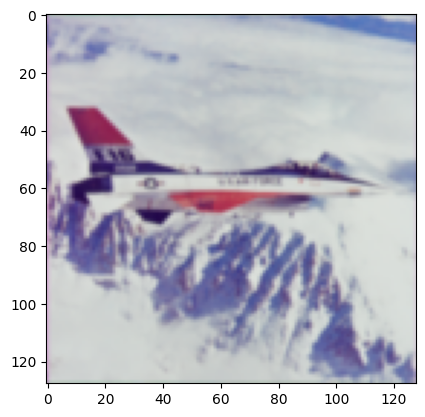

In [5]:
img = cv2.imread("./airplane.bmp")
img = (img / 255.).astype(np.float32)

# unfold_jit으로도 해보자
imdown = my_pyrdown(img, conv2d_naive_jit)
imdown = my_pyrdown(imdown, conv2d_naive_jit)
imdown = (imdown*255.).astype(np.uint8)

plt.imshow(cv2.cvtColor(imdown, cv2.COLOR_BGR2RGB))

print("numba, naive")
%timeit imdown = my_pyrdown(img, conv2d_naive_jit)
print("numba, im2col")
%timeit imdown = my_pyrdown(img, conv2d_unfold_jit)

## `numba`와 병렬 프로그래밍을 활용한 컨벌루션 구현

`numba`는 `prange` 모듈을 통해 `OpenMP` 라이브러리를 백엔드로 사용하여 루프에 대한 병렬화를 수행할 수 있다. 루프 병렬화는 단순히 `range`를 `prange`로 바꾸는 것만으로 수행할 수 있다. 그러나 주의해야 할 점은 루프 내에서 동일한 변수를 변경하려고 시도할 때 race condition이 발생한다는 점이다. 따라서 `conv2d_naive_pjit`의 경우 맨 안쪽 2개 루프는 `range`로 그대로 두어야 한다.

함수를 병렬화시키려면 `@jit` 데코레이터의 인자로 `parallel=True`를 전달해야 한다. `numba`의 병렬화 코드는 `conv2d.py`에서 확인 가능하다.

```python
# #####################
# numba parallel
# #####################

@jit(nopython=True, parallel=True)
def im2col_pjit(x: np.ndarray, filter_shape: np.ndarray):
    hx, wx = x.shape
    hk, wk = filter_shape[0], filter_shape[1]
    
    dst = np.zeros((hx-hk+1, wx-wk+1, hk, wk))

    for i in prange(hx-hk+1):
        for j in prange(wx-wk+1):
            for m in prange(hk):
                for n in prange(wk):
                    dst[i, j, m, n] = x[i+m, j+n]

    return dst.reshape((hx-hk+1)*(wx-wk+1), hk*wk)

@jit(nopython=True, parallel=True)
def conv2d_naive_pjit(x: np.ndarray, k: np.ndarray):
    if x.ndim != 2:
        raise ValueError("Input data shape must be 2-dimensional.")
    if k.ndim != 2:
        raise ValueError("Kernel data shape must be 2-dimensional.")
    
    hx, wx = x.shape
    hk, wk = k.shape

    if hk > hx or wk > wx:
        raise ValueError("Kernel must not be larger than input data.")
    
    dst = np.zeros((hx-hk+1, wx-wk+1))
    
    for i in prange(hx-hk+1):
        for j in prange(wx-wk+1):
            for m in range(hk):
                for n in range(wk):
                    dst[i, j] += x[i+m, j+n] * k[m, n]

    return dst

@jit(nopython=True, parallel=True)
def conv2d_unfold_pjit(x: np.ndarray, k: np.ndarray):
    if x.ndim != 2:
        raise ValueError("Input data shape must be 2-dimensional.")
    if k.ndim != 2:
        raise ValueError("Kernel data shape must be 2-dimensional.")
    
    hx, wx = x.shape
    hk, wk = k.shape

    if hk > hx or wk > wx:
        raise ValueError("Kernel must not be larger than input data.")
    
    col = im2col_jit(x, np.array([hk, wk]))
    dst = (np.dot(col, k.ravel())).reshape(hx-hk+1, wx-wk+1)

    return dst
```

In [6]:
# JIT 컴파일을 위한 더미 호출

_ = conv2d_naive_pjit(np.random.randn(16, 16), np.ones((3, 3)))
_ = conv2d_unfold_pjit(np.random.randn(16, 16), np.ones((3, 3)))

## `numba` + 병렬화 연산 결과 확인

병렬연산을 수행한 결과 단순한 구현의 실행속도는 약 4배 빨라졌으나 `im2col`을 사용한 연산의 속도는 크게 증가하지 않은 것을 볼 수 있었다.

numba, naive, parallel
2.96 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
numba, im2col, parallel
62.6 ms ± 142 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


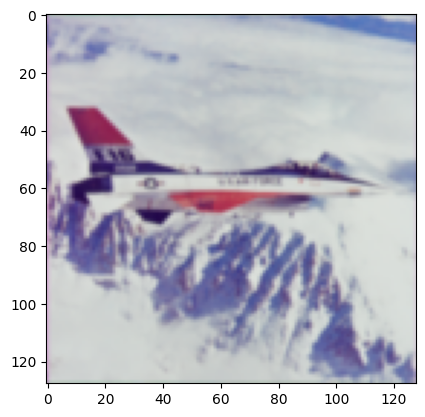

In [7]:
img = cv2.imread("./airplane.bmp")
img = (img / 255.).astype(np.float32)

# unfold_pjit으로도 해보자
imdown = my_pyrdown(img, conv2d_naive_pjit)
imdown = my_pyrdown(imdown, conv2d_naive_pjit)
imdown = (imdown*255.).astype(np.uint8)

plt.imshow(cv2.cvtColor(imdown, cv2.COLOR_BGR2RGB))

print("numba, naive, parallel")
%timeit imdown = my_pyrdown(img, conv2d_naive_pjit)
print("numba, im2col, parallel")
%timeit imdown = my_pyrdown(img, conv2d_unfold_pjit)

# C언어 함수를 파이썬에서 사용하기

파이썬에서는 외부 함수 인터페이스를 사용하여 C로 구현된 함수를 호출할 수 있도록 해 준다. 이 방법은 `numba`와 같은 JIT 컴파일 방식과 달리 코드 작성에 높은 오버헤드가 들지만, 코드 레벨 최적화를 수행할 수 있으면서 C언어의 장점인 빠른 속도를 취할 수 있어서 실행 속도가 중요한 응용에 유용하게 쓰일 수 있다.

C 함수를 가장 간단하게 쓸 수 있는 방법은 `ctypes`를 사용하는 것이다. 이 모듈은 C파이썬에서 기본적으로 제공하는 모듈로, 공유 라이브러리 형식으로 컴파일된 함수를 파이썬에서 호출할 수 있도록 해 준다.

이번 실습에서 사용하는 C 코드는 모두 `pyrconv2d.c`에 구현되어 있다.

## 컨벌루션 연산의 C코드 구현

`ctypes`를 파이썬에서 사용해 보기 앞서, 이미지 피라미드 구현에 사용되는 컨벌루션 함수를 C로 구현했다. 이 코드에서는 실행 속도를 높이기 위해 $5 \times 5$ 커널을 정적 배열로 선언해서 데이터를 stack 공간에 넣고, 합성곱 연산을 for loop를 쓰지 않고 수동으로 하드코딩했다. `im2col` 알고리즘에 대한 구현은 `ctypes` 실습에서는 생략했다.

```C
#define IDX2C(i, j, len) (((i) * (len)) + (j))

float kernel[5][5] = {{0.00390625f, 0.015625f, 0.0234375f, 0.015625f, 0.00390625f},
                      {0.015625f, 0.0625f, 0.09375f, 0.0625f, 0.015625f},
                      {0.0234375f, 0.09375f, 0.140625f, 0.09375f, 0.0234375f},
                      {0.015625f, 0.0625f, 0.09375f, 0.0625f, 0.015625f},
                      {0.00390625f, 0.015625f, 0.0234375f, 0.015625f, 0.00390625f}};

void pyrconv2d(float* src, float* dst, int h, int w) {
    size_t i = 0;
    size_t j = 0;

    for(i=0; i<h-4; i++) {
        for(j=0; j<w-4; j++) {
            dst[IDX2C(i, j, w-4)] = src[IDX2C(i, j, w)] * kernel[0][0];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i, j+1, w)] * kernel[0][1];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i, j+2, w)] * kernel[0][2];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i, j+3, w)] * kernel[0][3];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i, j+4, w)] * kernel[0][4];

            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+1, j, w)] * kernel[1][0];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+1, j+1, w)] * kernel[1][1];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+1, j+2, w)] * kernel[1][2];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+1, j+3, w)] * kernel[1][3];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+1, j+4, w)] * kernel[1][4];

            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+2, j, w)] * kernel[2][0];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+2, j+1, w)] * kernel[2][1];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+2, j+2, w)] * kernel[2][2];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+2, j+3, w)] * kernel[2][3];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+2, j+4, w)] * kernel[2][4];

            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+3, j, w)] * kernel[3][0];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+3, j+1, w)] * kernel[3][1];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+3, j+2, w)] * kernel[3][2];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+3, j+3, w)] * kernel[3][3];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+3, j+4, w)] * kernel[3][4];

            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+4, j, w)] * kernel[4][0];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+4, j+1, w)] * kernel[4][1];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+4, j+2, w)] * kernel[4][2];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+4, j+3, w)] * kernel[4][3];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+4, j+4, w)] * kernel[4][4];
        }
    }
    
    return;
}
```

이 코드는 입력과 출력 행렬을 float형 포인터로 받는다. 실제로 파이썬에서는 이 인자로 2차원 numpy 배열을 넘기게 되며, 자세한 코드는 후술한다. 중요한 점은 n차원 numpy array는 C 코드에서 행 우선(row-major) 방식으로 메모리가 저장된 1차원 배열로 다뤄진다는 것이다. 따라서 함수의 인자로 배열의 주소를 담은 포인터뿐만 아니라 배열의 너비와 높이를 인자로 같이 받아야 인덱싱을 할 수 있다.

2차원 인덱스 $(i,j)$를 통해 배열에 접근하기 위해서는 $(i,j)$로부터 실제 1차원 인덱스를 계산하는 과정이 필요하며, 이를 수행해주는 매크로가 `IDX2C`이다. 이 매크로는 인덱스 쌍과 2차원 배열의 가로 길이를 입력받아 실제 1차원 공간의 인덱스를 계산한다. $5 \times 5$ 컨벌루션을 수행하면 배열의 높이와 너비가 4씩 감소하므로 `dst`의 높이와 너비는 `src`의 높이와 너비보다 4만큼 작아서 `len`인자로 `w-4`를 넘겨야 하는 것을 볼 수 있다.

C에서 구현된 부분을 최소화하기 위해 이 코드에서는 경계조건이나 타입을 검사하지 않는다. 따라서 코드가 의도된 동작을 하도록 파이썬 구현부에서 이 함수로 들어가는 데이터의 에러처리를 수행하는 것이 바람직하다.

##  컨벌루션 연산의 C코드 구현 및 `OpenMP` 활용 병렬화

구현한 C코드를 가속화하기 위해 `OpenMP`를 사용하여 코드를 병렬화시켰다. `OpenMP`는 리눅스에서는 기본으로 설치되어 있으므로  `OpenMP`의 `C/C++` API를 자세히 설명하는 것은 본 세미나의 범위에 맞지 않으므로 생략한다. 추가적인 공부가 필요한 학생은 [튜토리얼 자료](https://www.openmp.org/wp-content/uploads/ntu-vanderpas.pdf)를 참고하면 좋다. C코드의 병렬 구현은 다음과 같다:

```C
void pyrconv2d_omp(float* src, float* dst, int h, int w) {
    size_t i = 0;
    size_t j = 0;

    #pragma omp parallel for default(none) collapse(2) \
        private(i, j) shared(src, kernel, dst, w, h)
    for(i=0; i<h-4; i++) {
        for(j=0; j<w-4; j++) {
            dst[IDX2C(i, j, w-4)] = src[IDX2C(i, j, w)] * kernel[0][0];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i, j+1, w)] * kernel[0][1];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i, j+2, w)] * kernel[0][2];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i, j+3, w)] * kernel[0][3];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i, j+4, w)] * kernel[0][4];

            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+1, j, w)] * kernel[1][0];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+1, j+1, w)] * kernel[1][1];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+1, j+2, w)] * kernel[1][2];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+1, j+3, w)] * kernel[1][3];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+1, j+4, w)] * kernel[1][4];

            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+2, j, w)] * kernel[2][0];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+2, j+1, w)] * kernel[2][1];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+2, j+2, w)] * kernel[2][2];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+2, j+3, w)] * kernel[2][3];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+2, j+4, w)] * kernel[2][4];

            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+3, j, w)] * kernel[3][0];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+3, j+1, w)] * kernel[3][1];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+3, j+2, w)] * kernel[3][2];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+3, j+3, w)] * kernel[3][3];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+3, j+4, w)] * kernel[3][4];

            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+4, j, w)] * kernel[4][0];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+4, j+1, w)] * kernel[4][1];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+4, j+2, w)] * kernel[4][2];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+4, j+3, w)] * kernel[4][3];
            dst[IDX2C(i, j, w-4)] += src[IDX2C(i+4, j+4, w)] * kernel[4][4];
        }
    }
    
    return;
}
```

## 코드 컴파일

C코드는 다음과 같은 과정으로 컴파일하여 공유 라이브러리를 만들어야 한다. 최종 생성된 공유 라이브러라 `pyrconv2d.so`는 기본 유저 공유 라이브러리 경로인 `/usr/local/lib/`에 복사한다. 다른 위치를 사용하고 싶은 경우 별도 configuration 파일에 공유 라이브러리 경로를 설정하면 되지만, 이 세미나의 범위를 벗어나므로 생략한다.

```bash
gcc -c -fPIC -O3 -fopenmp pyrconv2d.c
gcc -shared- fopenmp pyrconv2d.o -o pyrconv2d.so
sudo cp pyrconv2d.so /usr/local/lib/
```

## 파이썬에서 공유 라이브러리 호출

이제 `ctypes` 모듈을 사용하여 파이썬에서 C로 구현한 함수들을 호출할 수 있다. 바로 아래 셀에서 수행되는 과정을 순차적으로 설명하면 다음과 같다.

* line 3: 공유 라이브러리 파일을 파이썬 객체로 가져온다.
* line 4-5: 인자의 타입을 지정하는 데 쓸 변수이다. `TYPE_INT`는 `int`, `TYPE_PFLOAT`은 `*float`을 나타낸다.
* line 7-11: 정의된 두 함수 `pyrconv2d`, `pyrconv2d_omp`의 인자 타입, 리턴 타입을 지정한다. 인자 타입은 C 함수의 인자를 리스트 안에 순서대로 쓰면 되고, 두 함수의 리턴 타입이 `void`이므로 리턴 타입은 `None`으로 설정했다.
* line 13-: 실제 C언어로 구현된 컨벌루션을 호출하는 이미지 피라미드 함수이다. 이 함수에서 가장 주의해야 할 점은 `impad`와 `convx`각각 컨벌루션의 입력이 되는 패딩된 이미지와 컨벌루션의 출력은 데이터 저장 순서가 `OpenCV`에서 사용하는 `HWC`가 아니라 `CHW`로 저장되어 있다. 왜냐하면 C 함수의 인자로 전달되는 `numpy` array는 메모리 공간에서 연속된 위치에 저장되어 있어야 잘 작동하는데 `HWC` 순서로 배열 `arr`을 만든 후 `arr[:, :, 0]`과 같이 전달하면 실제로 저 배열의 원소들은 연속된 메모리 위치상에 없다. 따라서 C함수에 인자를 전달할 때는 `CHW` 형 배열에서 슬라이싱하여 전달하고 마지막에 값을 복사하는 방식을 사용했다.

In [8]:
import ctypes

_pyrconv2d = ctypes.CDLL("pyrconv2d.so")
TYPE_INT = ctypes.c_int
TYPE_PFLOAT = ctypes.POINTER(ctypes.c_float)

_pyrconv2d.pyrconv2d.argtypes = [TYPE_PFLOAT, TYPE_PFLOAT, TYPE_INT, TYPE_INT]
_pyrconv2d.pyrconv2d.restype = None

_pyrconv2d.pyrconv2d_omp.argtypes = [TYPE_PFLOAT, TYPE_PFLOAT, TYPE_INT, TYPE_INT]
_pyrconv2d.pyrconv2d_omp.restype = None

def cpyrdown(img):
    h, w, c = img.shape
    dst_h, dst_w, dst_c = (h + 1) // 2, (w + 1) // 2, c
    dst = np.zeros((dst_h, dst_w, dst_c), dtype=np.float32)
    impad = np.zeros((c, h+4, w+4), dtype=np.float32)
    convx = np.zeros((c, h, w), dtype=np.float32)

    impad[0,:,:] = np.pad(img[:,:,0], 2, mode="wrap").astype(np.float32)
    impad[1,:,:] = np.pad(img[:,:,1], 2, mode="wrap").astype(np.float32)
    impad[2,:,:] = np.pad(img[:,:,2], 2, mode="wrap").astype(np.float32)

    for i in range(3):
        psrc = impad[i,:,:].ctypes.data_as(TYPE_PFLOAT)
        pdst = convx[i,:,:].ctypes.data_as(TYPE_PFLOAT)
        _pyrconv2d.pyrconv2d(psrc, pdst, h+4, w+4)
    
    dst[:, :, 0] = convx[0, :, :][0::2, 0::2]
    dst[:, :, 1] = convx[1, :, :][0::2, 0::2]
    dst[:, :, 2] = convx[2, :, :][0::2, 0::2]

    return dst

def cpyrdown_omp(img):
    h, w, c = img.shape
    dst_h, dst_w, dst_c = (h + 1) // 2, (w + 1) // 2, c
    dst = np.zeros((dst_h, dst_w, dst_c), dtype=np.float32)
    impad = np.zeros((c, h+4, w+4), dtype=np.float32)
    convx = np.zeros((c, h, w), dtype=np.float32)

    impad[0,:,:] = np.pad(img[:,:,0], 2, mode="wrap").astype(np.float32)
    impad[1,:,:] = np.pad(img[:,:,1], 2, mode="wrap").astype(np.float32)
    impad[2,:,:] = np.pad(img[:,:,2], 2, mode="wrap").astype(np.float32)

    for i in range(3):
        psrc = impad[i,:,:].ctypes.data_as(TYPE_PFLOAT)
        pdst = convx[i,:,:].ctypes.data_as(TYPE_PFLOAT)
        _pyrconv2d.pyrconv2d_omp(psrc, pdst, h+4, w+4)
    
    dst[:, :, 0] = convx[0, :, :][0::2, 0::2]
    dst[:, :, 1] = convx[1, :, :][0::2, 0::2]
    dst[:, :, 2] = convx[2, :, :][0::2, 0::2]

    return dst

## `ctypes` 연산 결과 확인

시간 측정 결과는 C언어로 정적 최적화를 수행한 함수를 불러 쓰는 것이 가장 성능이 높다는 것을 보여 준다.

ctypes


3.07 ms ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
ctypes, parallel
1.73 ms ± 58.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


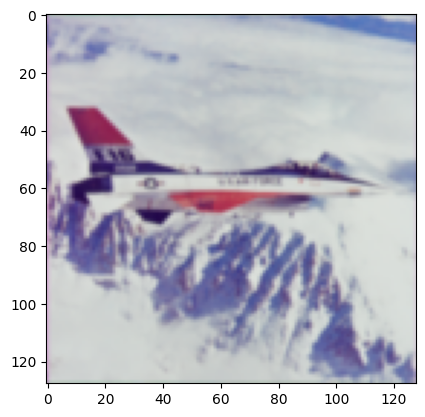

In [9]:
import matplotlib.pyplot as plt

img = cv2.imread("./airplane.bmp")
img = (img / 255.).astype(np.float32)

# cpyrdown으로도 해보자
imdown = cpyrdown_omp(img)
imdown = cpyrdown_omp(imdown)
imdown = (imdown*255.).astype(np.uint8)

plt.imshow(cv2.cvtColor(imdown, cv2.COLOR_BGR2RGB))

print("ctypes")
%timeit imdown = cpyrdown(img)
print("ctypes, parallel")
%timeit imdown = cpyrdown_omp(img)

## 성능 평가 정리

지금까지의 내용을 정리해서,
* 파이썬 인터프리터
* `numba` 최적화
* `ctypes` 인터페이스
* `scipy`의 `convolve2d` 함수
* `OpenCV`의 `pyrDown` 함수

를 비교 평가해 보았다. 낮은 성능을 보였던 `im2col` 구현은 평가에서 제외했다.


`numba`로 JIT 컴파일된 코드를 사용하는 것은 성능 향상에 아주 큰 도움을 주며 `scipy`의 `convolve2d` 함수보다 속도가 빠르다. `C` 함수를 직접 구현하여 정적 최적화를 수행하고 `ctypes`로 호출하면 `numba` 구현보다 더 높은 성능을 얻을 수 있으나 추가적인 구현 오버헤드가 생길 수 있다. 그러나 JIT 컴파일이나 외부 함수 인터페이스를 이용한 최적화를 사용해도 `OpenCV` 구현에 비하면 성능이 확연히 떨어진다. C++로 구현된 OpenCV [pyrDown 코드](https://github.com/egonSchiele/OpenCV/blob/master/modules/imgproc/src/pyramids.cpp)를 확인해보면, 컨벌루션 연산을 모두 수동으로 풀어서 어셈블리 코드 레벨로 최적화하고, `OpenCL`코드를 사용하여 병렬화를 수행하기 때문에, 알고리즘을 변경하지 않고 수행하는 이 실습의 최적화로는 그에 필적하는 성능을 얻기 힘들다. 

In [10]:
import timeit

x = np.arange(7)
times = []
times.append(timeit.timeit("my_pyrdown(img, conv2d_naive)", number=10, globals=globals()))
times.append(timeit.timeit("my_pyrdown(img, conv2d_naive_jit)", number=10, globals=globals()))
times.append(timeit.timeit("my_pyrdown(img, conv2d_naive_pjit)", number=10, globals=globals()))
times.append(timeit.timeit("cpyrdown(img)", number=10, globals=globals()))
times.append(timeit.timeit("cpyrdown_omp(img)", number=10, globals=globals()))
times.append(timeit.timeit("my_pyrdown(img, convolve2d, mode=\"valid\")", number=10, globals=globals()))
times.append(timeit.timeit("cv2.pyrDown(img)", number=10, globals=globals()))

caption = ["Python", "Numba", "Numba (parallel)", "C", "C (parallel)", "Scipy", "OpenCV"]

Text(0.5, 0, 'Method')

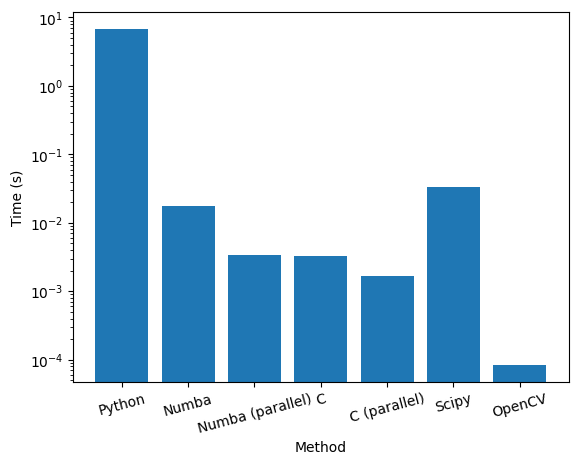

In [11]:
plt.bar(caption, np.array(times)/10)
plt.xticks(rotation=15)
plt.yscale("log")
plt.ylabel("Time (s)")
plt.xlabel("Method")